In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
#from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Conv1D
from keras.layers import LSTM

%matplotlib inline

Using TensorFlow backend.


In [4]:
movie_review = pd.read_csv(r'IMDB Dataset.csv')

In [6]:
movie_review.shape

(50000, 2)

In [7]:
movie_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
movie_review['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

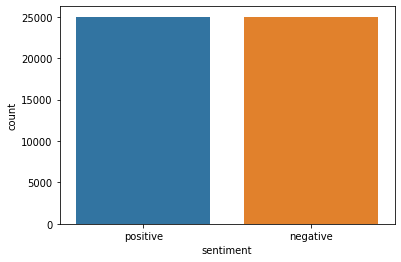

In [9]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_review)

In [15]:
# preprocess text

def preprocess_text(sen):
    
    # remove html tags
    sentence = remove_tags(sen)
    
    # remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    return sentence

In [13]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [16]:
X = []

sentences = list(movie_review['review'])

for sen in sentences:
    X.append(preprocess_text(sen))

In [17]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [19]:
y = movie_review['sentiment']

y = np.array(list(map(lambda x: 1 if x=='positive' else 0, y)))

In [20]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
X_train[0]

[1013,
 1,
 2433,
 3,
 36,
 187,
 1089,
 7,
 116,
 2372,
 36,
 1,
 58,
 21,
 489,
 101,
 9,
 23,
 749,
 2,
 526,
 449,
 9,
 466,
 86,
 79,
 1204,
 1,
 1852,
 502,
 5,
 37,
 1009,
 70,
 1,
 837,
 390,
 5,
 19,
 2,
 35,
 21,
 44,
 154,
 386,
 15,
 126,
 1,
 2533,
 1954,
 37,
 95,
 546,
 3,
 1082,
 36,
 2337,
 7,
 1,
 59,
 2,
 1,
 303,
 282,
 21,
 638,
 192,
 4,
 76,
 47,
 4253,
 4,
 9,
 1082,
 1,
 3573,
 3,
 21,
 246,
 68,
 1383,
 679,
 4,
 204,
 546,
 9,
 228,
 5,
 27,
 36,
 9,
 1,
 97,
 21,
 2306,
 29,
 142,
 2337,
 133,
 139,
 66,
 457,
 31,
 139,
 60,
 8,
 16,
 187,
 448,
 3,
 2533,
 31,
 46,
 339,
 513,
 46,
 98,
 3,
 241,
 226,
 194,
 8,
 16,
 39,
 3,
 12,
 1,
 2666,
 954,
 9,
 935]

In [28]:
vocab_size = len(tokenizer.word_index) + 1

In [29]:
vocab_size

92500

In [30]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [32]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [33]:
embeddings_dictionary = dict()
glove_file = open(r'glove.6B.100d.txt', encoding='utf8')

In [34]:
for line in glove_file:
    
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
    
glove_file.close()

In [36]:
embedding_matrix = zeros((vocab_size, 100))

In [38]:
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Neural network model with embedding-flatten-dense layers:

In [43]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length = maxlen, trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9250000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,260,001
Trainable params: 10,001
Non-trainable params: 9,250,000
_________________________________________________________________
None


In [46]:
history = model.fit(X_train, y_train, epochs=6)

Epoch 1/6
40000/40000 [==============================] - 7s 177us/step - loss: 0.5908 - acc: 0.6947
Epoch 2/6
40000/40000 [==============================] - 6s 151us/step - loss: 0.4994 - acc: 0.7604
Epoch 3/6
40000/40000 [==============================] - 6s 150us/step - loss: 0.4727 - acc: 0.7802
Epoch 4/6
40000/40000 [==============================] - 6s 160us/step - loss: 0.4552 - acc: 0.7894
Epoch 5/6
40000/40000 [==============================] - 6s 154us/step - loss: 0.4431 - acc: 0.7972
Epoch 6/6
40000/40000 [==============================] - 6s 152us/step - loss: 0.4371 - acc: 0.8000


In [47]:
score=model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 88us/step


In [48]:
print('Test Accuracy: ', score[1])

Test Accuracy:  0.7346


# Neural network model with embedding-LSTM-dense layers:

In [49]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [50]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9250000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,367,377
Trainable params: 117,377
Non-trainable params: 9,250,000
_________________________________________________________________
None


In [51]:
history = model.fit(X_train, y_train, epochs=6)

Epoch 1/6
40000/40000 [==============================] - 717s 18ms/step - loss: 0.4940 - acc: 0.7570
Epoch 2/6
40000/40000 [==============================] - 643s 16ms/step - loss: 0.3882 - acc: 0.8246
Epoch 3/6
40000/40000 [==============================] - 629s 16ms/step - loss: 0.3455 - acc: 0.8463
Epoch 4/6
40000/40000 [==============================] - 657s 16ms/step - loss: 0.3169 - acc: 0.8602
Epoch 5/6
40000/40000 [==============================] - 675s 17ms/step - loss: 0.2894 - acc: 0.8751
Epoch 6/6
40000/40000 [==============================] - 693s 17ms/step - loss: 0.2634 - acc: 0.8880


In [ ]:
score=model.evaluate(X_test, y_test)

In [ ]:
print('Test Accuracy: ', score[1])